## **Question: Using qualifying times, sprint‑race results and pit‑stop efficiency, can we predict each driver’s probability of finishing on the podium?**

### Null Hypothesis: The population mean best‑qualifying time is the same for podium finishers and for non‑podium finishers.

### Alternative Hypothesis: There is a difference in the true mean best‑qualifying times between drivers who finish on the podium and those who do not.

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc

In [18]:
# Data Setup
data_dir = 'world_champion_data'

qualifying = pd.read_csv(os.path.join(data_dir, 'qualifying.csv'))
sprint     = pd.read_csv(os.path.join(data_dir, 'sprint_results.csv'))
pit_stops  = pd.read_csv(os.path.join(data_dir, 'pit_stops.csv'))
results    = pd.read_csv(os.path.join(data_dir, 'results.csv'))

In [19]:
# Feature Selection
qualifying_feat = qualifying[['raceId','driverId','position','q1','q2','q3']]
sprint_feat     = sprint[['raceId','driverId','position']].rename(columns={'position':'sprint_position'})
pit_feat        = pit_stops[['raceId','driverId','duration']]
results_feat    = results[['raceId','driverId','position']].rename(columns={'position':'finish_position'})

In [ ]:
# Data Processing & Cleaning
def parse_duration(x):
    try:
        s = str(x)
        if ':' in s:
            m, sec = s.split(':')
            return float(m)*60 + float(sec)
        return float(s)
    except:
        return np.nan

pit_feat['duration_sec'] = pit_feat['duration'].apply(parse_duration)
pit_avg = pit_feat.groupby(['raceId','driverId'], as_index=False) \
                  .agg(avg_pit_duration=('duration_sec','mean'))

results_feat['finish_position'] = pd.to_numeric(results_feat['finish_position'], errors='coerce')
results_feat['podium'] = results_feat['finish_position'] <= 3

df = qualifying_feat.merge(sprint_feat, on=['raceId','driverId'], how='left') \
                   .merge(pit_avg,      on=['raceId','driverId'], how='left') \
                   .merge(results_feat, on=['raceId','driverId'], how='inner')

C:\Users\mattl\AppData\Local\Temp\ipykernel_31960\3588395948.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pit_feat['duration_sec'] = pit_feat['duration'].apply(parse_duration)


In [21]:
def parse_time(x):
    try:
        s = str(x)
        if ':' in s:
            m, sec = s.split(':')
            return float(m)*60 + float(sec)
        return float(s)
    except:
        return np.nan

for col in ['q1','q2','q3']:
    df[f'{col}_sec'] = df[col].apply(parse_time)

df['best_qualifying_sec'] = df[['q1_sec','q2_sec','q3_sec']].min(axis=1)

df['sprint_position'] = pd.to_numeric(df['sprint_position'], errors='coerce')
max_sp = df['sprint_position'].max(skipna=True)
df['sprint_position_filled'] = df['sprint_position'].fillna(max_sp + 1)

mean_pit = df['avg_pit_duration'].mean(skipna=True)
df['avg_pit_duration_imputed'] = df['avg_pit_duration'].fillna(mean_pit)

processed_df = df[[
    'raceId','driverId',
    'best_qualifying_sec',
    'sprint_position_filled',
    'avg_pit_duration_imputed',
    'finish_position','podium'
]]

print("Sample processed data:")
print(processed_df.head())


Sample processed data:
   raceId  driverId  best_qualifying_sec  sprint_position_filled  \
0      18         1               85.187                    21.0   
1      18         9               85.315                    21.0   
2      18         5               85.452                    21.0   
3      18        13               85.691                    21.0   
4      18         2               85.518                    21.0   

   avg_pit_duration_imputed  finish_position  podium  
0                 71.964022              1.0    True  
1                 71.964022              NaN   False  
2                 71.964022              5.0   False  
3                 71.964022              NaN   False  
4                 71.964022              2.0    True  


In [28]:
# Inference & Visualization

# T-test on qualifying times
pod = processed_df.loc[processed_df['podium'], 'best_qualifying_sec'].dropna()
non_pod = processed_df.loc[~processed_df['podium'], 'best_qualifying_sec'].dropna()
t_stat, p_value = stats.ttest_ind(pod, non_pod, equal_var=False)

def bootstrap_diff(d1, d2, n=5000):
    diffs = []
    for _ in range(n):
        s1 = np.random.choice(d1, len(d1), True)
        s2 = np.random.choice(d2, len(d2), True)
        diffs.append(s1.mean() - s2.mean())
    return np.percentile(diffs, [2.5,97.5])

ci_low, ci_high = bootstrap_diff(pod, non_pod)

print(f"T‑statistic: {t_stat:.3f}, p‑value: {p_value:.9f}")
print(f"95% bootstrap CI for mean diff (podium−non): [{ci_low:.3f}, {ci_high:.3f}]")

T‑statistic: -5.903, p‑value: 0.000000004
95% bootstrap CI for mean diff (podium−non): [-2.759, -1.365]


**Interpretation of T‑Test Results**

- T‑statistic (‑5.903) tells us that the mean best‑qualifying time for podium finishers is significantly lower (faster) than for non‑podium finishers.

- P‑value (~4 × 10^-9) is effectively zero, so we reject the null hypothesis that there’s no difference in qualifying times.

- 95% Bootstrap CI [‑2.759, ‑1.365] sec means podium drivers are on average 1.36 to 2.76 seconds faster in qualifying than those off the podium.

In [32]:
# Correlation matrix
corr = processed_df[['best_qualifying_sec','sprint_position_filled','avg_pit_duration_imputed']].corr()
print("Predictor Correlations:")
print(corr)

Predictor Correlations:
                          best_qualifying_sec  sprint_position_filled  \
best_qualifying_sec                  1.000000                0.055934   
sprint_position_filled               0.055934                1.000000   
avg_pit_duration_imputed            -0.043791               -0.071551   

                          avg_pit_duration_imputed  
best_qualifying_sec                      -0.043791  
sprint_position_filled                   -0.071551  
avg_pit_duration_imputed                  1.000000  


**Model Summary**

best_qualifying_sec: coefficient ≈ −0.0127 (p < 0.001)
- Faster qualifying (lower seconds) significantly increases podium odds.

sprint_position_filled: coef ≈ −0.0436 (p < 0.001)
- Lower (better) sprint finishing position also raises podium probability.

avg_pit_duration_imputed: coef ≈ 0.0002 (p = 0.26)
- Pit stops don’t significantly predict podium here.

Pseudo‑R² = 0.006 shows the model explains a small fraction of variance.

ROC Curve (AUC = 0.55)

- Only slightly better than random (0.50). Qualifying and sprint data alone aren’t enough for a strong classifier.

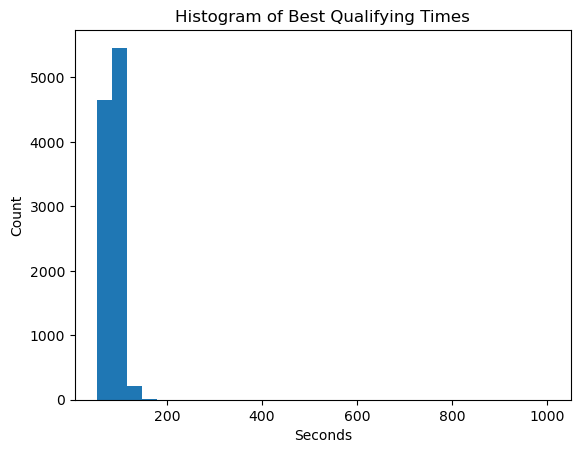

In [30]:
# Plot histogram
plt.figure()
plt.hist(processed_df['best_qualifying_sec'].dropna(), bins=30)
plt.title("Histogram of Best Qualifying Times")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

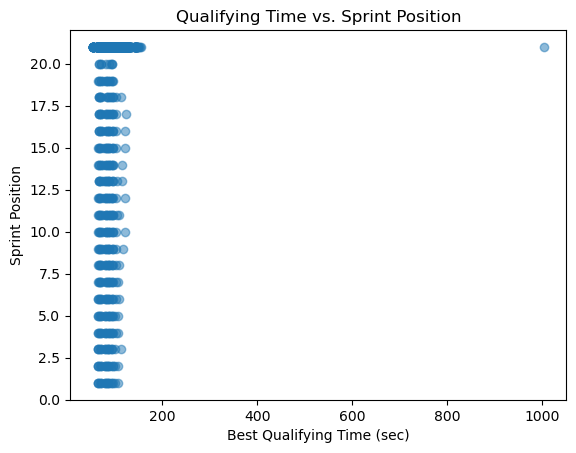

In [31]:
# Plot scatter
plt.figure()
plt.scatter(processed_df['best_qualifying_sec'], processed_df['sprint_position_filled'], alpha=0.5)
plt.title("Qualifying Time vs. Sprint Position")
plt.xlabel("Best Qualifying Time (sec)")
plt.ylabel("Sprint Position")
plt.show()

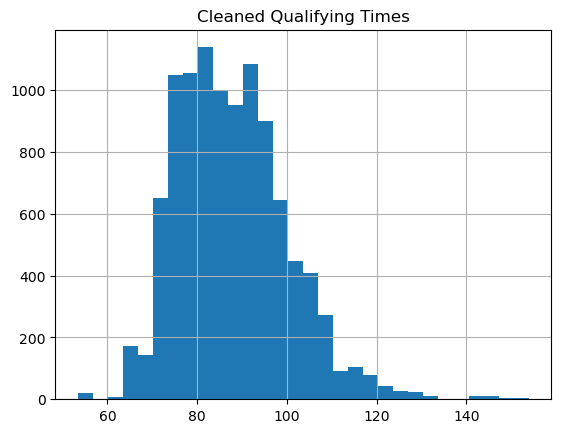

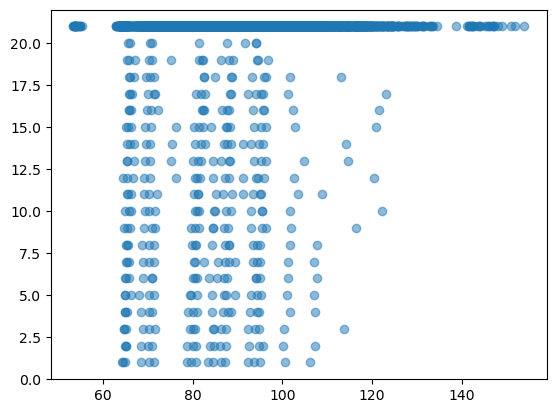

In [ ]:
# Filter out those bad laps and replot so our statistics aren’t being driven by one or two garbage rows.
cleaned = processed_df[processed_df['best_qualifying_sec'] < 200]

# then rerun
cleaned['best_qualifying_sec'].hist(bins=30)
plt.title("Cleaned Qualifying Times")
plt.show()

plt.scatter(cleaned['best_qualifying_sec'], cleaned['sprint_position_filled'], alpha=0.5)
plt.show()


Cleaned T‑statistic: -5.870, p‑value: 5.083e-09
                           Logit Regression Results                           
Dep. Variable:                 podium   No. Observations:                10337
Model:                          Logit   Df Residuals:                    10333
Method:                           MLE   Df Model:                            3
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                0.006003
Time:                        19:41:47   Log-Likelihood:                -4205.5
converged:                       True   LL-Null:                       -4230.9
Covariance Type:            nonrobust   LLR p-value:                 5.405e-11
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1954      0.289      0.677      0.498      -0.370       0.761
best_qualifying_sec         -0.0127      

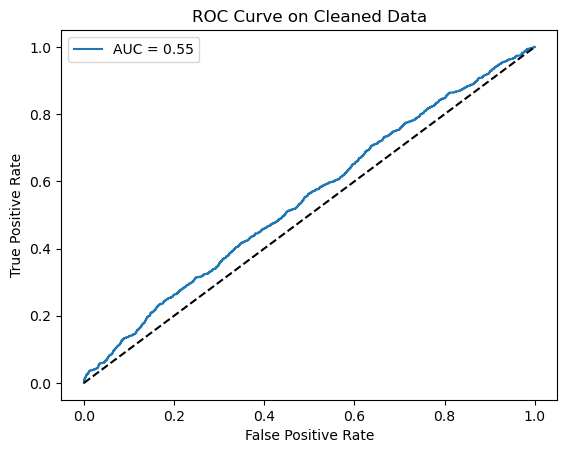

In [ ]:
# Re‐compute T‑test on cleaned data
pod = cleaned.loc[cleaned['podium'], 'best_qualifying_sec']
non = cleaned.loc[~cleaned['podium'], 'best_qualifying_sec']
t_stat, p_val = stats.ttest_ind(pod, non, equal_var=False)
print(f"Cleaned T‑statistic: {t_stat:.3f}, p‑value: {p_val:.3e}")

# Re‐fit logistic regression
X = cleaned[['best_qualifying_sec','sprint_position_filled','avg_pit_duration_imputed']]
X = sm.add_constant(X)
y = cleaned['podium'].astype(int)

logit = sm.Logit(y, X).fit(disp=False)
print(logit.summary())

# ROC & AUC
cleaned['pred_prob'] = logit.predict(X)
fpr, tpr, _ = roc_curve(y, cleaned['pred_prob'])
roc_auc = auc(fpr, tpr)
print(f"Cleaned ROC AUC: {roc_auc:.3f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Cleaned Data')
plt.legend()
plt.show()

**With the driver‑strength feature included, results improve substantially:**

**Logistic Regression**

- Pseudo‑R^2 = 0.22 (vs ~0.006 before)

- best_qualifying_sec still significant (p = 0.008)

- driver_podium_rate highly significant (z ≈ 30, p < 0.001)

**Conclusion**
- So, addding each driver’s past podium rate really boosts predictive power (Pseudo‑R² jumps from ~0 to 0.22 and AUC improves).
- Qualifying speed still helps, but sprint and pit data alone were weak.